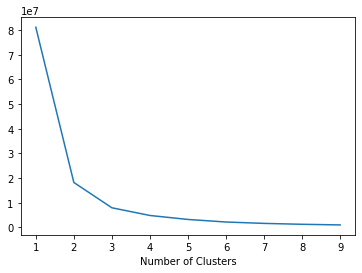

count    29705.000000
mean        81.353981
std         52.259083
min          0.000000
25%         36.000000
50%         74.000000
75%        126.000000
max        183.000000
Name: Recency, dtype: float64
                    Recency                                                          
                      count        mean        std    min    25%    50%    75%    max
new_RecencyCluster                                                                   
0                    6250.0  158.678080  13.790423  136.0  146.0  159.0  171.0  183.0
1                    5949.0  113.109598  12.418399   92.0  103.0  112.0  123.0  135.0
2                    6150.0   70.398374  12.264765   50.0   60.0   71.0   81.0   91.0
3                   11356.0   28.094664  12.496810    0.0   19.0   31.0   37.0   49.0


<Figure size 432x288 with 0 Axes>

In [56]:
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import random
import plotly.offline as pyoff
import plotly.graph_objs as go
from sklearn import preprocessing
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

np.random.seed(42)
random.seed(42)
warnings.filterwarnings('ignore')

# Read the data
df1 = pd.read_csv('./data/olist_orders_dataset.csv')
df2 = pd.read_csv('./data/olist_customers_dataset.csv')
df3 = pd.read_csv('./data/olist_order_payments_dataset.csv')
df4 = pd.read_csv('./data/olist_order_items_dataset.csv')

# Get only the required columns from customers dataset
cols = ['order_id', 'customer_id', 'order_purchase_timestamp']
orders = df1[cols]
orders = orders.set_index('customer_id')

# Get only the required columns from orders dataset
cols = ['customer_id', 'customer_unique_id']
customers = df2[cols]
customers = customers.set_index('customer_id')

# Merge to create a dataframe containing customer_id and first purchase date
customers_orders = pd.merge(orders, customers, on='customer_id')
customers_orders['PurchaseTimeStamp'] = pd.to_datetime(customers_orders['order_purchase_timestamp'])

#create 3m and 6m dataframes
customers_orders_6m = customers_orders[(customers_orders.PurchaseTimeStamp.dt.date < date(2018,1,1)) & (customers_orders.PurchaseTimeStamp.dt.date >= date(2017,7,1))].reset_index(drop=True)
customers_orders_12m = customers_orders[(customers_orders.PurchaseTimeStamp.dt.date < date(2018,12,1)) & (customers_orders.PurchaseTimeStamp.dt.date >= date(2018,1,1))].reset_index(drop=True)

#####################################################################################################
#####################################################################################################
# Recency Score
#create a generic user dataframe to keep CustomerID and new segmentation scores
cust_unique = pd.DataFrame(customers_orders_6m['customer_unique_id'].unique())
cust_unique.columns = ['CustomerID']

# get the max purchase date for each customer and create a dataframe with it
cust_max_purchase = customers_orders_6m.groupby('customer_unique_id').PurchaseTimeStamp.max().reset_index()
cust_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

# For recency calculation take the observation point as the max invoice date in our dataset
cust_max_purchase['Recency'] = (cust_max_purchase['MaxPurchaseDate'].max() - cust_max_purchase['MaxPurchaseDate']).dt.days

# merge this dataframe with cust_unique to get the recency score for each unique customer
rfm_score = pd.merge(cust_unique, cust_max_purchase[['CustomerID','Recency']], on='CustomerID')

sse={}
cluster_recency = rfm_score[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(cluster_recency)
    cluster_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.show()
plt.clf()

# plt.figure(figsize = (8,7))
# sns.lineplot(x="Cluster Number", y="Inertia", data=pd.DataFrame(sse.items(), columns=['Cluster Number', 'Inertia'])).set_title('Customer Recency Clusters')
# plt.show()


#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm_score[['Recency']])
rfm_score['RecencyCluster'] = kmeans.predict(rfm_score[['Recency']])

#function for ordering cluster numbers 0 being worst and 4 being best
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":new_cluster_field_name})
    return df_final

# order the recency cluster
rfm_score = order_cluster('RecencyCluster', 'Recency',rfm_score,False)
print(rfm_score.Recency.describe())
print(rfm_score.groupby('new_RecencyCluster').describe())

plot_data = [
    go.Histogram(
        x=rfm_score['Recency']
    )
]
plot_layout = go.Layout(
        title='Recency',
        xaxis_title = "Days since last purchase",
        yaxis_title = "Number of Customers",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [57]:
# Frequency Score
# get order counts for each customer_unique_id and create a dataframe with it
customer_frequency = customers_orders_6m.groupby('customer_unique_id').PurchaseTimeStamp.count().reset_index()
customer_frequency.columns = ['CustomerID','Frequency']

# add this data to our main dataframe
rfm_score = pd.merge(rfm_score, customer_frequency, on='CustomerID')

# k-means clustering with 4 clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm_score[['Frequency']])
rfm_score['FrequencyCluster'] = kmeans.predict(rfm_score[['Frequency']])

# order the frequency cluster
rfm_score = order_cluster('FrequencyCluster', 'Frequency', rfm_score,True)

# see details of each cluster
print(rfm_score.Frequency.describe())
print(rfm_score.groupby('new_FrequencyCluster')['Frequency'].describe())

count    29705.000000
mean         1.026427
std          0.180173
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: Frequency, dtype: float64
                        count      mean       std  min  25%  50%  75%  max
new_FrequencyCluster                                                      
0                     28987.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
1                       670.0  2.000000  0.000000  2.0  2.0  2.0  2.0  2.0
2                        43.0  3.139535  0.350605  3.0  3.0  3.0  3.0  4.0
3                         5.0  5.600000  1.341641  5.0  5.0  5.0  5.0  8.0


In [58]:
# Revenue Score
# Get only the required columns from order_items table
cols = ['order_id', 'price']
order_items = df4[cols]
# we need even duplicates to calculate the price
order_items = order_items.set_index('order_id')
# Combine the prices of items within same order
order_items = order_items.groupby(['order_id'])['price'].sum().reset_index()

# merge with customers_orders_6m on order_id
orders_cust_price = pd.merge(customers_orders_6m, order_items, on='order_id')

# calculate the Revenue per customer
orders_cust_price = orders_cust_price.groupby(['customer_unique_id'])['price'].sum().reset_index()
orders_cust_price.columns = ['CustomerID','Revenue']

# customers who has not paid for the orders will be removed from the rfm_score dataset
rfm_score = pd.merge(orders_cust_price, rfm_score, on='CustomerID')

#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(orders_cust_price[['Revenue']])
rfm_score['RevenueCluster'] = kmeans.predict(rfm_score[['Revenue']])

# order the cluster numbers
rfm_score = order_cluster('RevenueCluster', 'Revenue', rfm_score,True)

# show details of the dataframe
print(rfm_score.Revenue.describe())
print(rfm_score.groupby('new_RevenueCluster')['Revenue'].describe())

count    29383.000000
mean       140.040493
std        210.657678
min          2.290000
25%         49.000000
50%         88.900000
75%        153.890000
max      13440.000000
Name: Revenue, dtype: float64
                      count          mean         std       min       25%      50%        75%       max
new_RevenueCluster                                                                                     
0                   26184.0     90.611575   59.335443      2.29     44.90     77.8    126.000    262.50
1                    2855.0    435.303058  163.792567    263.92    300.00    369.9    539.945    919.99
2                     343.0   1416.927464  501.819620    928.86   1099.35   1299.9   1599.495   5934.60
3                       1.0  13440.000000         NaN  13440.00  13440.00  13440.0  13440.000  13440.00


In [59]:
# calculate overall score and use mean() to see details
rfm_score['OverallScore'] = rfm_score['new_RecencyCluster'] + rfm_score['new_FrequencyCluster'] + rfm_score['new_RevenueCluster']
print(rfm_score.groupby('OverallScore')['Recency','Frequency','Revenue'].mean())

# segment the customer based on RFM overall score
rfm_score['Segment'] = 'Low-Value'
rfm_score.loc[rfm_score['OverallScore']>3,'Segment'] = 'Mid-Value'
rfm_score.loc[rfm_score['OverallScore']>5,'Segment'] = 'High-Value'
rfm_score.head()

                 Recency  Frequency      Revenue
OverallScore                                    
0             158.716076   1.000000    89.848467
1             117.901037   1.015468   120.740104
2              76.008433   1.021251   133.403636
3              31.945121   1.015440   124.111112
4              34.018490   1.188752   461.389931
5              32.268817   1.532258  1016.699892
6              28.350000   2.650000   865.684500
7              25.200000   5.600000   546.168000


,CustomerID,Revenue,Recency,new_RecencyCluster,Frequency,new_FrequencyCluster,new_RevenueCluster,OverallScore,Segment
0,0000f6ccb0745a6a4b88665a16c9f078,25.99,80,2,1,0,0,2,Low-Value
1,0004aac84e0df4da2b147fca70cf8255,180.00,47,3,1,0,0,3,Low-Value
2,0006fdc98a402fceb4eb0ee528f6a8d4,13.90,166,0,1,0,0,0,Low-Value
3,00082cbe03e478190aadbea78542e933,79.00,42,3,1,0,0,3,Low-Value
4,000a5ad9c4601d2bbdd9ed765d5213b3,76.99,142,0,1,0,0,0,Low-Value


In [0]:
# # plotting the distribution of the continous feature set
# sns.set(palette='muted', color_codes=True, style='whitegrid')
# fig, axs = plt.subplots(1, 1, figsize=(22, 5))
# sns.despine(left=True)
# # sns.scatterplot(x='Recency', y='Frequency', hue='Segment', data=rfm_score, size='Segment', sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
# sns.scatterplot(x='Frequency', y='Revenue', hue='Segment', data=rfm_score, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
# # sns.scatterplot(x='Recency', y='Revenue', hue='Segment', data=rfm_score, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
# # axs.set_title('Customer Segments by Recency & Frequency')
# axs.set_title('Customer Segments by Frequency & Revenue')
# # axs.set_title('Customer Segments by Recency & Revenue')
# plt.show()
# a = 'test'

In [61]:
# calculate 12 months LTV for each customer
orders_cust_price = pd.merge(customers_orders_12m, order_items, on='order_id')

#calculate the Revenue per customer
user_12m = orders_cust_price.groupby(['customer_unique_id'])['price'].sum().reset_index()
user_12m.columns = ['CustomerID','m12_Revenue']

#plot LTV histogram
plot_data = [
    go.Histogram(
        x=user_12m['m12_Revenue']
    )
]

plot_layout = go.Layout(
        title='12m Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [62]:
# To view the correlation between 6 month LTV and feature set created
tx_merge = pd.merge(rfm_score, user_12m, on='CustomerID', how='left')
tx_merge = tx_merge.dropna()

plot_data = [
    go.Scatter(
        x=tx_merge.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_merge.query("Segment == 'Low-Value'")['m12_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_merge.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_merge.query("Segment == 'Mid-Value'")['m12_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_merge.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_merge.query("Segment == 'High-Value'")['m12_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "12m LTV"},
        xaxis= {'title': "RFM Score"},
        title='Correlation'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [63]:
tx_merge.head()

,CustomerID,Revenue,Recency,new_RecencyCluster,Frequency,new_FrequencyCluster,new_RevenueCluster,OverallScore,Segment,m12_Revenue
27,004288347e5e88a27ded2bb23747066c,229.99,157,0,1,0,0,0,Low-Value,87.90
33,004b45ec5c64187465168251cd1c9c2f,59.90,121,1,1,0,0,1,Low-Value,27.00
123,011b4adcd54683b480c4d841250a987f,69.49,131,1,1,0,0,1,Low-Value,113.94
166,01886ef98f995e4f2dd75a1d04c97397,25.26,34,3,1,0,0,3,Low-Value,16.00
389,03d4953a455f8489e712ea80699de878,29.98,108,1,1,0,0,1,Low-Value,24.99


In [64]:
# cluster customers based on their predicted LTV
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m12_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m12_Revenue']])


# order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm12_Revenue',tx_merge,True)
tx_merge.head()


,CustomerID,Revenue,Recency,new_RecencyCluster,Frequency,new_FrequencyCluster,new_RevenueCluster,OverallScore,Segment,m12_Revenue,new_LTVCluster
0,004288347e5e88a27ded2bb23747066c,229.99,157,0,1,0,0,0,Low-Value,87.90,0
1,004b45ec5c64187465168251cd1c9c2f,59.90,121,1,1,0,0,1,Low-Value,27.00,0
2,011b4adcd54683b480c4d841250a987f,69.49,131,1,1,0,0,1,Low-Value,113.94,0
3,01886ef98f995e4f2dd75a1d04c97397,25.26,34,3,1,0,0,3,Low-Value,16.00,0
4,03d4953a455f8489e712ea80699de878,29.98,108,1,1,0,0,1,Low-Value,24.99,0


In [65]:
tx_cluster = tx_merge.copy()

#see details of the clusters
# print(tx_cluster.groupby('new_LTVCluster')['m12_Revenue'].describe())

#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster['Segment'])
tx_class = pd.concat([tx_cluster, pd.get_dummies(tx_cluster['Segment'])], axis=1)

# drop irrelvant columns
tx_class = tx_class.drop(['CustomerID', 'm12_Revenue', 'Segment'],axis=1)

#calculate and show correlations
corr_matrix = tx_class.corr()
print(corr_matrix['new_LTVCluster'].sort_values(ascending=False))

#create X and y, X will be feature set and y is the label - LTV
X = tx_class.drop('new_LTVCluster',axis=1)
y = tx_class['new_LTVCluster']
y = y.to_frame()
# X.sample(n=5)
y.sample(n=5)
y.to_csv('./y1.csv')


new_LTVCluster          1.000000
Revenue                 0.176481
new_RevenueCluster      0.162565
Mid-Value               0.051889
Frequency               0.050168
Recency                 0.040950
new_FrequencyCluster    0.039768
OverallScore            0.019817
High-Value             -0.001237
new_RecencyCluster     -0.040153
Low-Value              -0.043825
Name: new_LTVCluster, dtype: float64


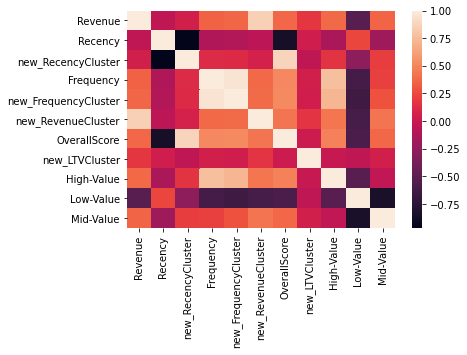

In [66]:
corrmat = tx_class.corr()
# print(corrmat)
sns.heatmap(corrmat)

In [67]:
columns = np.full((corrmat.shape[0],), True, dtype=bool)
for i in range(corrmat.shape[0]):
    for j in range(i+1, corrmat.shape[0]):
        if corrmat.iloc[i,j] >= 0.9:
            if columns[j]:
              columns[j] = False
print(columns)
selected_columns = tx_class.columns[columns]
print(selected_columns)

[ True  True  True  True False  True  True  True  True  True  True]
Index(['Revenue', 'Recency', 'new_RecencyCluster', 'Frequency', 'new_RevenueCluster', 'OverallScore', 'new_LTVCluster', 'High-Value', 'Low-Value', 'Mid-Value'], dtype='object')


In [0]:
# split training and test sets 80%-20%
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=56)

# don't need to divide our data into training and test sets as CV is used
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0, random_state=0)

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier

classifiers =[]
clf_xgb = xgboost.XGBClassifier()
classifiers.append(clf_xgb)
clf_svm = svm.SVC()
classifiers.append(clf_svm)
clf_dt = tree.DecisionTreeClassifier()
classifiers.append(clf_dt)
clf_nb = GaussianNB()
classifiers.append(clf_nb)
clf_knn = KNeighborsClassifier(n_neighbors=5)
classifiers.append(clf_knn)

# for clf in classifiers:
#     clf.fit(X_train, y_train)
#     y_pred= clf.predict(X_test)
#     acc = accuracy_score(y_test, y_pred)
#     print("Accuracy of %s is %s"%(clf.__class__.__name__, acc))
#     cm = confusion_matrix(y_test, y_pred)
#     print("Confusion Matrix of %s is %s"%(clf.__class__.__name__, cm))

In [70]:
# cross-validated
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

for clf in classifiers:
  all_accuracies = cross_val_score(estimator=clf, X=X, y=y, cv=10)
  print("Average accuracy of %s is %s"%(clf.__class__.__name__, all_accuracies.mean()))
  # print(all_accuracies)
  # print(all_accuracies.mean())
  # print(all_accuracies.std())
  y_pred = cross_val_predict(clf, X, y, cv=10)
  print(confusion_matrix(y, y_pred))
  # print(classification_report(y, y_pred))


Average accuracy of XGBClassifier is 0.7119472789115646
[[338  32   7]
 [ 76   7   2]
 [ 22   1   2]]
Average accuracy of SVC is 0.7428571428571428
[[357  18   2]
 [ 80   5   0]
 [ 23   2   0]]
Average accuracy of DecisionTreeClassifier is 0.58078231292517
[[268  71  38]
 [ 59  18   8]
 [ 20   4   1]]
Average accuracy of GaussianNB is 0.1151360544217687
[[ 24  25 328]
 [  6  12  67]
 [  3   2  20]]
Average accuracy of KNeighborsClassifier is 0.7099914965986395
[[338  33   6]
 [ 77   7   1]
 [ 22   2   1]]


Cross-Validation accuracy obtianed: 0.71


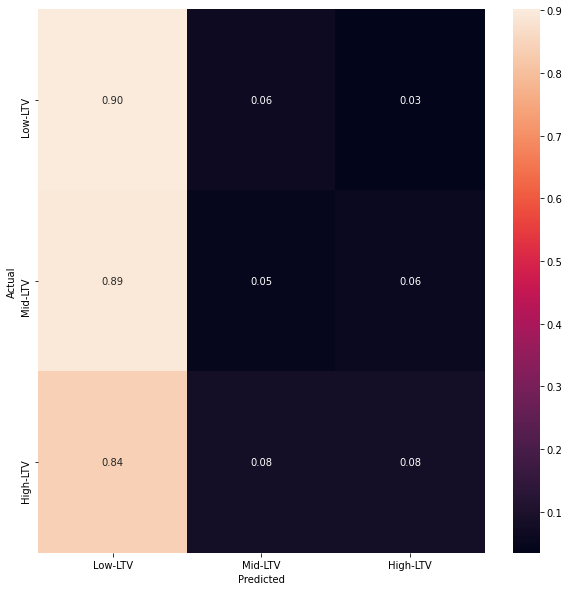

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       377
           1       0.13      0.05      0.07        85
           2       0.10      0.08      0.09        25

    accuracy                           0.71       487
   macro avg       0.34      0.34      0.33       487
weighted avg       0.63      0.71      0.66       487



In [71]:
def plot_cm(cm):
# Normalise
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['Low-LTV', 'Mid-LTV', 'High-LTV'], yticklabels=['Low-LTV', 'Mid-LTV', 'High-LTV'])
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show(block=False)

all_accuracies = cross_val_score(estimator=clf_dt, X=X, y=y, cv=10)

#Optimizing Decision Tree Performance
clf_dt_optimized = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3)
print('Cross-Validation accuracy obtianed: {0:.2f}'.format(cross_val_score(estimator=clf_dt_optimized, X=X, y=y, cv=10).mean()))
y_pred = cross_val_predict(clf_dt_optimized, X, y, cv=10)
# print(confusion_matrix(y, y_pred))
plot_cm(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

[0.6218537414965987, 0.6996598639455782, 0.6853316326530613, 0.7100340136054422, 0.7099914965986395, 0.7181972789115646, 0.7181547619047619, 0.7366071428571428, 0.7386904761904762, 0.7345238095238095, 0.7407738095238094, 0.7448979591836734, 0.7407738095238094, 0.7428571428571428, 0.7470238095238095, 0.7491071428571427, 0.7449404761904762, 0.7511904761904762, 0.7511904761904762, 0.7511904761904762, 0.7532738095238095, 0.7595238095238095, 0.7553571428571428, 0.7574404761904762, 0.7574404761904762]


Text(0, 0.5, 'Cross-Validated Accuracy')

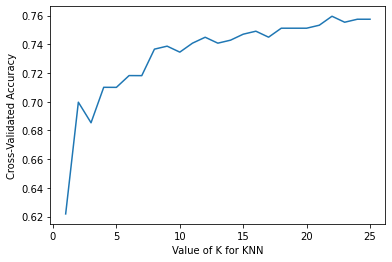

In [72]:
# try K=1 through K=25 and record testing accuracy
k_range = range(1, 26)

# We can create Python dictionary using [] or dict()
scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    clf_knn_optimized = KNeighborsClassifier(n_neighbors=k)
    scores.append(cross_val_score(estimator=clf_knn_optimized, X=X, y=y, cv=10).mean())
print(scores)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

Cross-Validation accuracy obtianed: 0.69


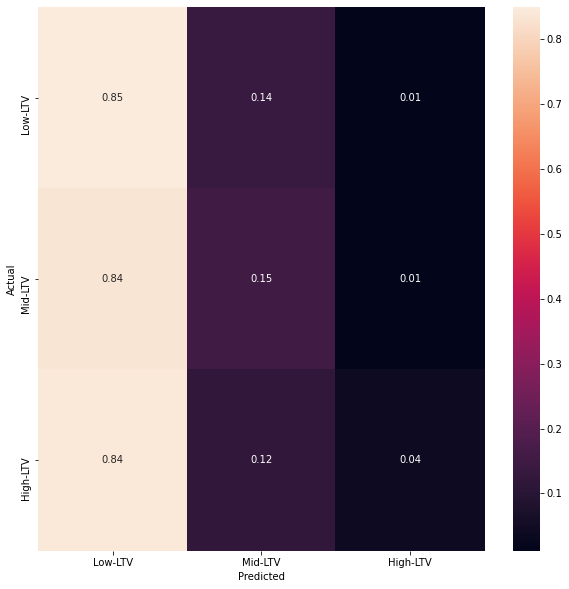

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       377
           1       0.19      0.15      0.17        85
           2       0.14      0.04      0.06        25

    accuracy                           0.69       487
   macro avg       0.37      0.35      0.35       487
weighted avg       0.64      0.69      0.66       487



In [73]:
#Optimizing KNN Performance
clf_knn_optimized = KNeighborsClassifier(n_neighbors=3)
print('Cross-Validation accuracy obtianed: {0:.2f}'.format(cross_val_score(estimator=clf_knn_optimized, X=X, y=y, cv=10).mean()))
y_pred = cross_val_predict(clf_knn_optimized, X, y, cv=10)
# print(confusion_matrix(y, y_pred))
plot_cm(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))